<a href="https://colab.research.google.com/github/fosfrancesco/pitch-spelling/blob/main/rnncrf_pitch_spelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#! pip install --upgrade pytorch-crf

In [2]:
# from google.colab import files

import music21 as m21
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
import pickle

from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import sklearn
import music21 as m21
from collections import Counter

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torch.nn.functional as F
#from torchcrf import CRF

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from tqdm import tqdm, tqdm_notebook, notebook
import pickle

from sklearn.metrics import accuracy_score

import time

import kmeans1d
import jenkspy

from collections import defaultdict, Counter
# import optuna

# Pitch Spelling and ks Prediction

Dataset: different authors from ASAP collection
Challenges:
- extremely long sequences
- small dataset

## Import ASAP dataset

In [3]:
# !git clone https://github.com/fosfrancesco/pitch-spelling.git

basepath = "./" #to change if running locally or on colab
# load the asap datasets with ks
with open(Path('./asapks.pkl'), 'rb') as fid:
     full_dict_dataset = pickle.load( fid)

######## Note for Nicolas: I called it "dict_dataset", but it is a list of dictionaries
paths = list(set([e["original_path"] for e in full_dict_dataset ]))

# print(paths)
print(len(paths), "different pieces")
print("Average number of notes: ", np.mean([len(e["midi_number"]) for e in full_dict_dataset ]))


222 different pieces
Average number of notes:  2410.253424657534


## Chose the convenient data augmentation
For each chromatic interval, take only the diatonic transposition that produce the smallest number of accidentals (or the original if present).

Then remove the pieces with ks that have more than 7 sharps or 7 flats.

In [4]:
from pitches import keep_best_transpositions
from utils import root_folder
                                                    
dict_dataset = keep_best_transpositions(full_dict_dataset)
# #test if it worked
# for i,e in enumerate(dict_dataset):
#     print(e["original_path"], e["transposed_of"], e["key_signatures"])
#     print(e["pitches"][:10])
#     print(e["midi_number"][:10])
#     if i == 100:
#         break

composer_per_piece = [root_folder(p) for p in paths]
c = Counter(composer_per_piece)

print(f"Dataset has {len(dict_dataset)} pieces.")
print(f"By composer: {', '.join(map(lambda item: item[0] + ': ' + str(item[1]), c.items()))}")

No options for Liszt/Transcendental_Etudes/10/xml_score.musicxml . Chromatic:  1
No options for Liszt/Transcendental_Etudes/10/xml_score.musicxml . Chromatic:  6
No options for Liszt/Transcendental_Etudes/4/xml_score.musicxml . Chromatic:  2
No options for Liszt/Transcendental_Etudes/4/xml_score.musicxml . Chromatic:  4
No options for Liszt/Transcendental_Etudes/4/xml_score.musicxml . Chromatic:  9
No options for Chopin/Sonata_2/2nd/xml_score.musicxml . Chromatic:  4
No options for Chopin/Sonata_2/2nd/xml_score.musicxml . Chromatic:  6
No options for Chopin/Sonata_2/2nd/xml_score.musicxml . Chromatic:  9
No options for Chopin/Sonata_2/2nd/xml_score.musicxml . Chromatic:  11
No options for Ravel/Gaspard_de_la_Nuit/1_Ondine/xml_score.musicxml . Chromatic:  4
No options for Liszt/Transcendental_Etudes/11/xml_score.musicxml . Chromatic:  1
No options for Liszt/Transcendental_Etudes/11/xml_score.musicxml . Chromatic:  6
No options for Chopin/Sonata_2/1st_no_repeat/xml_score.musicxml . Chrom

In [5]:
# remove pieces from asap that are in Musedata
print(len(paths), "initial pieces")
paths = [p for p in paths if p!= "Bach/Prelude/bwv_865/xml_score.musicxml"]

#remove mozart Fantasie because of incoherent key signature
paths = [p for p in paths if p!= 'Mozart/Fantasie_475/xml_score.musicxml']

print(len(paths), "pieces after removing overlapping with musedata and Mozart Fantasie")

222 initial pieces
220 pieces after removing overlapping with musedata and Mozart Fantasie


Train and validation lenghts:  163 29
Remaining composers: ['Schumann', 'Rachmaninoff', 'Chopin', 'Mozart', 'Bach', 'Schubert', 'Beethoven', 'Haydn']


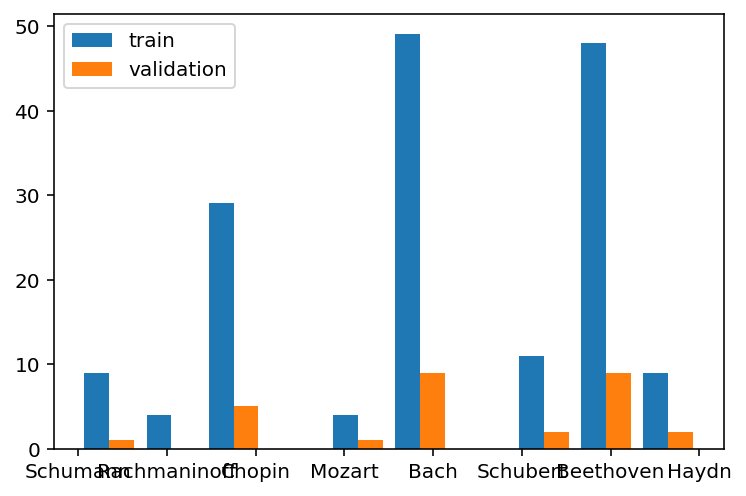

In [6]:
# Temporary remove composer with only one piece, because they create problems with sklearn stratify
one_piece_composers = ['Balakirev','Prokofiev','Brahms','Glinka', 'Debussy', 'Ravel', 'Scriabin','Liszt']
paths = [p for p in paths if root_folder(p) not in one_piece_composers]

# Divide train and validation set
path_train, path_validation = sklearn.model_selection.train_test_split(paths, test_size=0.15, stratify=[root_folder(p) for p in paths ])
print("Train and validation lenghts: ",len(path_train),len(path_validation))

#need to find a better way to visualize this
composers = list(set([root_folder(p) for p in paths ]))
print(f"Remaining composers: {composers}")

train_composer = [composers.index(root_folder(p)) for p in path_train]
val_composer = [composers.index(root_folder(p)) for p in path_validation]

_ = plt.hist([train_composer, val_composer], label=['train', 'validation'])
_ = plt.legend(loc='upper left')
_ = plt.xticks(list(range(len(composers))), composers)


## Transform the input into a convenient format for the Model

In [7]:
from pitches import PITCHES
from pitches import KEY_SIGNATURES
from utils import PAD
# Helper functions to feed the correct input into the NN 

N_DURATION_CLASSES = 4

accepted_pitches = [ii for i in PITCHES.values() for ii in i]
pitch_to_ix = {p: accepted_pitches.index(p) for p in accepted_pitches}
ks_to_ix = {k: KEY_SIGNATURES.index(k) for k in KEY_SIGNATURES}
#add PADDING TAD
pitch_to_ix[PAD] = len(accepted_pitches)
ks_to_ix[PAD] = len(KEY_SIGNATURES)

midi_to_ix = {m: m for m in range(12)}
#add PADDING TAD
midi_to_ix[PAD] = 12

# print(midi_to_ix[1])
# print(len(midi_to_ix))



# class Pitch2Diatonic():
#     def __call__(self, in_seq):
#         return [p for p in in_seq]

class Pitch2Int():
    def __call__(self, in_seq):
        idxs = [pitch_to_ix[w] for w in in_seq]
        return idxs
    
class Ks2Int():
    def __call__(self, in_seq):
        idxs = [ks_to_ix[w] for w in in_seq]
        return idxs

class Int2Pitch():
    def __call__(self, in_seq):
        return [accepted_pitches[i] for i in in_seq]

class OneHotEncoder():
    def __init__(self, alphabet_len):
        self.alphabet_len = alphabet_len
        
    def __call__(self, sample,weights = None):
        onehot = np.zeros([len(sample), self.alphabet_len])
        tot_chars = len(sample)
        onehot[np.arange(tot_chars), sample] = 1
        return onehot
    
class DurationOneHotEncoder():
    def __init__(self, pitch_alphabet_len, n_dur_class = 4):
        self.pitch_alphabet_len = pitch_alphabet_len
        self.dur_alphabet_len = n_dur_class
        
    def __call__(self, sample, durs):
        sample = torch.tensor(sample,dtype=torch.long)
        onehot_pitch = torch.nn.functional.one_hot(sample,self.pitch_alphabet_len)
        #compute breaks in duration list
        clusters, centroids = kmeans1d.cluster(durs, N_DURATION_CLASSES)   
        quantized_durations = torch.tensor(clusters,dtype=torch.long)
        onehot_duration = torch.nn.functional.one_hot(quantized_durations,self.dur_alphabet_len)
        return torch.cat([onehot_pitch,onehot_duration],1)
    
        
class ToTensorFloat():
    def __call__(self, sample, durs = None):
        if type(sample) is torch.Tensor:
            return sample.float()
        else:
            return torch.tensor(sample,dtype=torch.float)

class ToTensorLong():
    def __call__(self, sample):
        if type(sample) is torch.Tensor:
            return sample.long()
        else:
            return torch.tensor(sample,dtype=torch.long)
    
class MultInputCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, sample, durs):
        for t in self.transforms:
            sample = t(sample, durs)
        return sample


### Define the preprocessing pipeline
transform_diat = transforms.Compose([Pitch2Int(),ToTensorLong()])
transform_chrom = MultInputCompose([DurationOneHotEncoder(len(midi_to_ix),N_DURATION_CLASSES),ToTensorFloat()])
transform_key = transforms.Compose([Ks2Int(),ToTensorLong()])


print(set([ks_to_ix[ks] for piece in dict_dataset for ks in piece["key_signatures"]]))
print(ks_to_ix[PAD])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
15


In [8]:
# Create the dataset
from datasets import PSDataset

train_dataset = PSDataset(dict_dataset,path_train, transform_chrom,transform_diat,transform_key,True, sort = True)
validation_dataset = PSDataset(dict_dataset,path_validation, transform_chrom,transform_diat,transform_key, False)

print(len(train_dataset),len(validation_dataset))


# test if it works
for chrom,diat,ks,seq_len in train_dataset:
    print(chrom.shape)
    print(ks.shape)
    print("Division", diat.shape[0]/65)
#     print(torch.argmax(chrom[0:30],1))
#     # print([diatonic_pitches[p.item()] for p in diat[0:30]])
#     print([accepted_pitches[p.item()] for p in diat[0:30]])
    print([p.item() for p in ks[-20:]])
    print([p for p in chrom[-10:,:]])
    print(seq_len)

 tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.])]
462
torch.Size([462, 17])
torch.Size([462])
Division 7.107692307692307
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.

In [9]:
from torch.nn.utils.rnn import pad_sequence

def pad_collate(batch):
    (chromatic_seq, diatonic_seq,ks_seq, l) = zip(*batch)
    
    chromatic_seq_pad = pad_sequence(chromatic_seq, padding_value=midi_to_ix[PAD])
    diatonic_seq_pad = pad_sequence(diatonic_seq, padding_value=pitch_to_ix[PAD])
    ks_seq_pad = pad_sequence(ks_seq, padding_value=ks_to_ix[PAD])

    #sort the sequences by length
    seq_lengths, perm_idx = torch.Tensor(l).sort(0, descending=True)
    chromatic_seq_pad = chromatic_seq_pad[:,perm_idx,:]
    diatonic_seq_pad = diatonic_seq_pad[:,perm_idx]
    ks_seq_pad = ks_seq_pad[:,perm_idx]

    return chromatic_seq_pad, diatonic_seq_pad,ks_seq_pad, seq_lengths

data_loader = DataLoader(dataset=validation_dataset,  num_workers =1, batch_size=4, shuffle=True, collate_fn=pad_collate)

#test if it work
for batch in data_loader:
    print(batch[0].shape,batch[1].shape,batch[2].shape)
    print(batch[0])
    break

torch.Size([2776, 4, 17]) torch.Size([2776, 4]) torch.Size([2776, 4])
tensor([[[ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  ...,  0.,  1.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  1.,  0.],
         [ 1.,  0.,  0.,  ...,  0.,  0.,  0.]],

        ...,

        [[ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
         [12., 12., 12.,  ..., 12., 12., 12.],
         [12., 12., 12.,  ..., 12., 12., 12.],
         [12., 12., 12.,  ..., 12., 12., 12.]],

        [[ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
         [12., 12., 12.,  ..., 12., 12., 12.],
         [12., 12., 12.,  ..., 12., 12., 12.],
         [12., 

## Model Definition

In [10]:
# TODO: search over the best hyperparameters

In [49]:
n_epochs = 30
HIDDEN_DIM = 96 #as it is implemented now, this is double the hidden_dim
LEARNING_RATE = 0.05
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 8
MOMENTUM = 0.9
RNN_LAYERS = 1

#ks rnn hyperparameter
HIDDEN_DIM2= 48

#attention hyperparameter
NUM_HEAD = 2
NUM_LANDMARKS = 64 #should we make this depending on the seq length for each batch? 


train_dataset = PSDataset(dict_dataset,path_train, transform_chrom,transform_diat,transform_key,True,sort=True, truncate = None)
validation_dataset = PSDataset(dict_dataset,path_validation, transform_chrom,transform_diat,transform_key, False)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,collate_fn=pad_collate)
val_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False,collate_fn=pad_collate)

# model = torch.load("./models/temp/model_temp_epoch30-to_restart.pkl")

from models import RNNTagger
from models import RNNMultiTagger
from models import RNNNystromAttentionTagger
from models import RNNMultNystromAttentionTagger

# model = RNNTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,pitch_to_ix,ks_to_ix, n_layers =RNN_LAYERS)
# model = RNNMultiTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,pitch_to_ix,ks_to_ix, n_layers =RNN_LAYERS)
# model = RNNNystromAttentionTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,pitch_to_ix,ks_to_ix, n_layers =RNN_LAYERS,num_head=NUM_HEAD,num_landmarks=NUM_LANDMARKS)
model = RNNMultNystromAttentionTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,pitch_to_ix,ks_to_ix, n_layers =RNN_LAYERS,hidden_dim2=HIDDEN_DIM2,num_head=NUM_HEAD,num_landmarks=NUM_LANDMARKS)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum = MOMENTUM,weight_decay=WEIGHT_DECAY)
from train import training_loop
history = training_loop(model,optimizer,train_dataloader,val_dataloader, 1)

# After the final evaluation, we print more detailed evaluation statistics,
plt.plot(history['train_loss'])
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy_pitch'])
plt.plot(history['val_accuracy_ks'])
plt.legend(['training loss', 'training accuracy', 'validation_accuracy_pitch','validation_accuracy_ks'])

Training device: cuda


RuntimeError: Input and parameter tensors are not at the same device, found input tensor at cuda:0 and parameter tensor at cpu

In [ ]:
#find the best working model on the accuracy
max_accuracy = np.max(history['val_accuracy_pitch'])
best_epoch = np.argmax(history['val_accuracy_pitch'])
print("Best validation accuracy: ",max_accuracy, "at epoch",best_epoch)

plt.plot(history['train_loss'])
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy_pitch'])
plt.plot(history['val_accuracy_ks'])
plt.legend(['training loss', 'training accuracy', 'validation_accuracy_pitch','validation_accuracy_ks'])

In [ ]:
# torch.save(model, "./models/model_asap_crf200dur.pkl")
# files.download("model_asap_crf300.pkl")

### print attention

## Test on Mdata dataset

In [ ]:
#model = torch.load("./models/model_RNNks.pkl")
model = torch.load("./models/temp/model_temp_epoch6.pkl")

In [53]:
def evaluate(model, dataset_path, device=None):
    # load the dataset
    with open(dataset_path, 'rb') as fid:
        full_mdata_dict_dataset = pickle.load( fid)
            
    # add dummy ks to have the same format as asap
    for e in full_mdata_dict_dataset:
        e["key_signatures"] = np.zeros(len(e["pitches"]))
    mdata_paths = list(set([e["original_path"] for e in full_mdata_dict_dataset ]))

    # # remove the symbphony No.100 from Haydn because of the enharmonic transposition
    # paths.remove("datasets\\opnd\\haydndoversyms-10004m.opnd-m")

    # print(paths)
    print(len(mdata_paths), "different pieces")
    print("Average number of notes: ", np.mean([len(e["midi_number"]) for e in full_mdata_dict_dataset ]))
    
    mdata_dataset = PSDataset(full_mdata_dict_dataset,mdata_paths, transform_chrom,transform_diat,transform_key,sort=False, augment_dataset=False)
    mdata_dataloader = DataLoader(mdata_dataset,  batch_size=2, shuffle=False, collate_fn=pad_collate)

    if device is None:
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    print(f"Using device: {device}")

    all_inputs = []
    all_predicted_pitch = []
    all_predicted_ks = []
    all_pitches = []
    all_ks = []
    model.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # Disable gradient tracking
        for seqs, pitches,ks,lens in mdata_dataloader:
            # Move data to device
            seqs = seqs.to(device)

            # Predict the model's output on a batch.
            predicted_pitch,predicted_ks = model.predict(seqs,lens)                   
            # Update the evaluation statistics.
            for i,p in enumerate(predicted_pitch):
                all_inputs.append(torch.argmax(seqs[0:int(lens[i]),i,:].cpu(),1).numpy())
                all_predicted_pitch.append(p)
                all_predicted_ks.append(predicted_ks[i])
                all_pitches.append(pitches[0:int(lens[i]),i])
                all_ks.append(ks[0:int(lens[i]),i])

    # Divide accuracy according to author
    authors = []

    for sequence in all_inputs:
    #     print(sequence)
        author = [e["original_path"].split("\\")[-1][:3] for e in full_mdata_dict_dataset
                if len(e["midi_number"]) == len(sequence) and
                list(e["midi_number"]) ==list(sequence) ]
        assert len(author) == 1
        authors.append(author[0])

    considered_authors = list(set(authors))
    print(considered_authors)

    errors_per_author_pitch = {}
    accuracy_per_author_pitch = {}
    notes_per_author = {}
    for ca in considered_authors:
        ca_predicted_pitch = np.concatenate([all_predicted_pitch[i] for i,a in enumerate(authors) if a == ca])
        ca_predicted_ks = np.concatenate([all_predicted_ks[i] for i,a in enumerate(authors) if a == ca])
        ca_pitches = np.concatenate([all_pitches[i] for i,a in enumerate(authors) if a == ca])
        ca_ks = np.concatenate([all_ks[i] for i,a in enumerate(authors) if a == ca])

        ca_acc_pitch = accuracy_score(ca_predicted_pitch,ca_pitches)
        
        accuracy_per_author_pitch[ca] = float(ca_acc_pitch)
        errors_per_author_pitch[ca] = int(len(ca_pitches) - sum(np.equal(ca_predicted_pitch,ca_pitches)))
        notes_per_author[ca] = len(ca_pitches)

    print("Pitch Statistics----------------")
    print(errors_per_author_pitch)
    print(accuracy_per_author_pitch)
    print(notes_per_author)
    print("Total errors :", sum([e for e in errors_per_author_pitch.values()]))
    print("Error rate:")
    print({k:(1-accuracy_per_author_pitch[k])*100 for k in accuracy_per_author_pitch.keys() })

    print("Total error rate:", sum(errors_per_author_pitch.values())/sum(notes_per_author.values())*100 )



In [54]:
musedata_noisy_path = Path(basepath,'./datasets/musedata_noisy.pkl')
evaluate(model, musedata_noisy_path)

216 different pieces
Average number of notes:  907.2777777777778
Using device: cuda
['bee', 'hay', 'han', 'cor', 'moz', 'tel', 'viv', 'bac']
Pitch Statistics----------------
{'bee': 18817, 'hay': 19754, 'han': 20260, 'cor': 20139, 'moz': 19525, 'tel': 20154, 'viv': 20000, 'bac': 20699}
{'bee': 0.23173968072510512, 'hay': 0.19338505512454063, 'han': 0.1730612244897959, 'cor': 0.17776507573592454, 'moz': 0.20286600800195967, 'tel': 0.17738775510204083, 'viv': 0.18357349879577092, 'bac': 0.15531524178739034}
{'bee': 24493, 'hay': 24490, 'han': 24500, 'cor': 24493, 'moz': 24494, 'tel': 24500, 'viv': 24497, 'bac': 24505}
Total errors : 159348
Error rate:
{'bee': 76.8260319274895, 'hay': 80.66149448754594, 'han': 82.6938775510204, 'cor': 82.22349242640755, 'moz': 79.71339919980403, 'tel': 82.26122448979592, 'viv': 81.64265012042291, 'bac': 84.46847582126097}
Total error rate: 81.31161594513502


### BEst accuracy with ks
n_epochs = 30
HIDDEN_DIM = 96
LEARNING_WEIGHT = 0.05
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 8
MOMENTUM = 0.9
RNN_LAYERS = 1

model = RNNMultiTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,pitch_to_ix,ks_to_ix, n_layers =RNN_LAYERS)

Model available in: ""./models/model_RNNks.pkl""
accuracy on validation set 0.9424
Trained on all asap dataset

{'cor': 4, 'viv': 29, 'moz': 70, 'bac': 13, 'han': 15, 'bee': 99, 'hay': 273, 'tel': 8}
{'cor': 0.9998366880333156, 'viv': 0.9988161815732539, 'moz': 0.9971421572630031, 'bac': 0.9994694960212201, 'han': 0.9993877551020408, 'bee': 0.9959580288245621, 'hay': 0.9888525928950592, 'tel': 0.9996734693877551}
{'cor': 24493, 'viv': 24497, 'moz': 24494, 'bac': 24505, 'han': 24500, 'bee': 24493, 'hay': 24490, 'tel': 24500}
Total errors : 511


Epoch 22: train loss = 0.4723, train_accuracy: 0.9533,val_accuracy_pitch: 0.9424,val_accuracy_ks: 0.7938, time = 106.7093

